## Problem.1

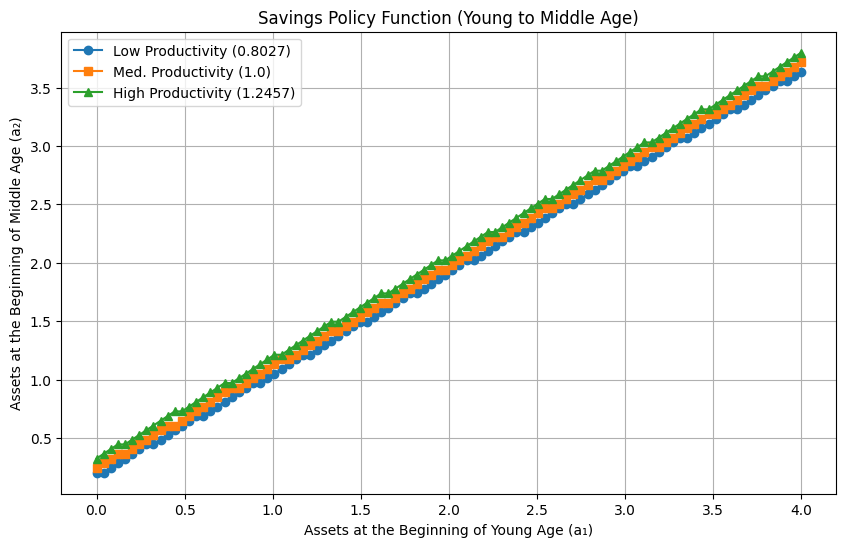

In [25]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 2.0
beta = 0.985**20
r = 1.025**20 - 1.0
JJ = 3 # Number of periods
l = np.array([0.8027, 1.0, 1.2457]) # Productivity levels
NL = 3 # Number of productivity levels

# Transition matrix for middle-age income uncertainty
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
])

# Grids
a_l = 0.0
a_u = 4.0 
NA = 100
a = np.linspace(a_l, a_u, NA)

# Utility function
def util(c, gamma):
    if c > 0:
        return (c**(1 - gamma)) / (1 - gamma)
    else:
        return -np.inf

# --- Solve for Policy Function WITHOUT Pension ---
# This is the variable that will be stored in memory
v_no_pension = np.zeros((JJ, NA, NL))
aplus_no_pension = np.zeros((JJ - 1, NA, NL)) 

# Period 3 (Old Age)
for ia in range(NA):
    v_no_pension[2, ia, :] = util((1.0 + r) * a[ia], gamma)

# Period 2 (Middle Age)
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v_no_pension[2, iap, 0]
        aplus_no_pension[1, ia, il] = a[np.argmax(reward)]
        v_no_pension[1, ia, il] = np.max(reward)

# Period 1 (Young Age)
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            EV = np.sum(prob[il, :] * v_no_pension[1, iap, :])
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        aplus_no_pension[0, ia, il] = a[np.argmax(reward)]

# --- Plotting the Results for Problem 1 ---
plt.figure(figsize=(10, 6))
plt.plot(a, aplus_no_pension[0, :, 0], marker='o', linestyle='-', label='Low Productivity (0.8027)')
plt.plot(a, aplus_no_pension[0, :, 1], marker='s', linestyle='-', label='Med. Productivity (1.0)')
plt.plot(a, aplus_no_pension[0, :, 2], marker='^', linestyle='-', label='High Productivity (1.2457)')
plt.title("Savings Policy Function (Young to Middle Age)")
plt.xlabel("Assets at the Beginning of Young Age (a₁)")
plt.ylabel("Assets at the Beginning of Middle Age (a₂)")
plt.legend()
plt.grid(True)
plt.show()

## Problem.2
老年期にすべての個人に年金を支給することを考える。
そのための原資として、中年期にのみ労働所得に対して定率30%の所得税を課す。
中年期における政府の総税収はいくらか？
政府はその総税収を利子率個人の資産と同じ利子率で運用し、老年期にそこから個人個人に均等に定額の年金を給付する。
一人当たりの年金額を求めよ

In [26]:
# --- Calculate Tax Revenue and Pension Benefit ---
tax_rate = 0.30

# Initial population distribution (1/3 for each type)
mu_1 = np.full(NL, 1.0/NL)

# Calculate middle-age population distribution using the transition matrix
mu_2 = mu_1 @ prob

# Calculate average labor income in middle age
average_labor_income_mid = np.sum(mu_2 * l)
total_tax_revenue = average_labor_income_mid * tax_rate

# Calculate the per-person pension benefit
pension_benefit = total_tax_revenue * (1.0 + r)

print(f"Total Tax Revenue: {total_tax_revenue:.4f}")
print(f"Per-Person Pension Benefit: {pension_benefit:.4f}")

Total Tax Revenue: 0.3043
Per-Person Pension Benefit: 0.4986


## Problem.3
問2の年金が導入された場合の個人の最適化問題を再度解き、
問1と同様にグラフを描き、年金導入前と導入後の貯蓄行動を比較せよ。その経済学的な直感も述べよ。

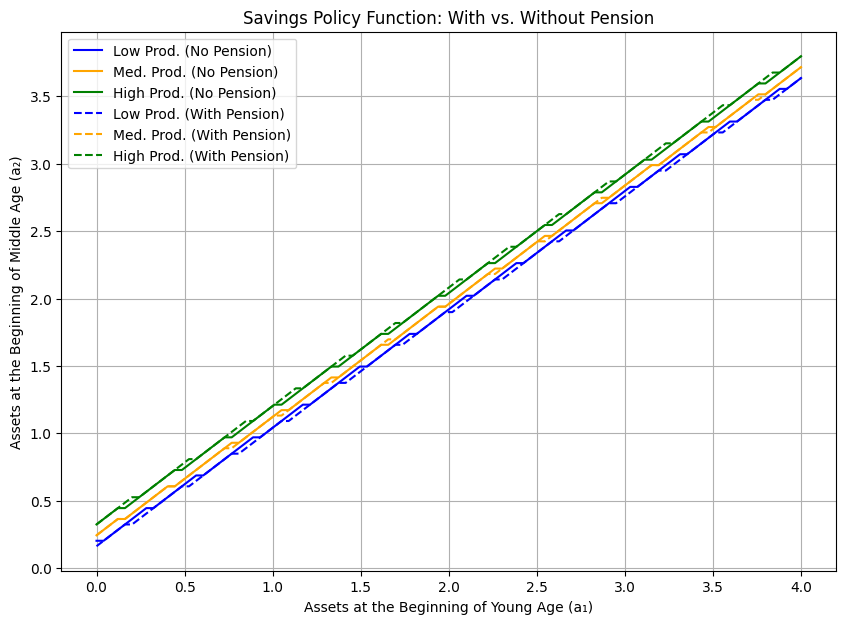

In [27]:
# --- Solve for Policy Function WITH Pension ---
# Initialize new arrays for the pension scenario
v_pension = np.zeros((JJ, NA, NL))
aplus_pension = np.zeros((JJ - 1, NA, NL))

# Period 3 (with pension)
for ia in range(NA):
    consumption = (1.0 + r) * a[ia] + pension_benefit
    v_pension[2, ia, :] = util(consumption, gamma)
    
# Period 2 (with tax)
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            # Income is now after-tax
            consumption = l[il] * (1 - tax_rate) + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v_pension[2, iap, 0]
        aplus_pension[1, ia, il] = a[np.argmax(reward)]
        v_pension[1, ia, il] = np.max(reward)

# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            EV = np.sum(prob[il, :] * v_pension[1, iap, :])
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        aplus_pension[0, ia, il] = a[np.argmax(reward)]

# --- Plotting the Comparison ---
plt.figure(figsize=(10, 7))
# No Pension lines (using the variable from the first cell)
plt.plot(a, aplus_no_pension[0, :, 0], color='blue', linestyle='-', label='Low Prod. (No Pension)')
plt.plot(a, aplus_no_pension[0, :, 1], color='orange', linestyle='-', label='Med. Prod. (No Pension)')
plt.plot(a, aplus_no_pension[0, :, 2], color='green', linestyle='-', label='High Prod. (No Pension)')
# With Pension lines
plt.plot(a, aplus_pension[0, :, 0], color='blue', linestyle='--', label='Low Prod. (With Pension)')
plt.plot(a, aplus_pension[0, :, 1], color='orange', linestyle='--', label='Med. Prod. (With Pension)')
plt.plot(a, aplus_pension[0, :, 2], color='green', linestyle='--', label='High Prod. (With Pension)')

plt.title("Savings Policy Function: With vs. Without Pension")
plt.xlabel("Assets at the Beginning of Young Age (a₁)")
plt.ylabel("Assets at the Beginning of Middle Age (a₂)")
plt.legend()
plt.grid(True)
plt.show()

## Problem.4
ここで全員の若年期の期初の資産をゼロとする。
若年期の異なる生産性タイプの期待生涯効用を人口比率で加重平均した「経済全体の平均期待生涯効用」は、年金導入によって増加するか、減少するか？
その経済学的な直感とともに、このシミュレーションによると日本で年金の制度は維持すべきなのか論じよ。

In [28]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
gamma = 2.0
beta = 0.985**20
r = 1.025**20 - 1.0
JJ = 3
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
])

# --- Grids ---
# CORRECTED: Increased the upper bound of the asset grid
a_l = 0.0
a_u = 25.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# --- Utility Function ---
def util(c, gamma):
    if c > 0:
        return (c**(1 - gamma)) / (1 - gamma)
    else:
        return -np.inf

# --- Solve for Policy Function WITHOUT Pension (Problem 1) ---
v_no_pension = np.zeros((JJ, NA, NL))
aplus_no_pension = np.zeros((JJ - 1, NA, NL))
# Period 3
for ia in range(NA):
    v_no_pension[2, ia, :] = util((1.0 + r) * a[ia], gamma)
# Period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v_no_pension[2, iap, 0]
        aplus_no_pension[1, ia, il] = a[np.argmax(reward)]
        v_no_pension[1, ia, il] = np.max(reward)
# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            EV = np.sum(prob[il, :] * v_no_pension[1, iap, :])
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        aplus_no_pension[0, ia, il] = a[np.argmax(reward)]


# --- Calculate Tax Revenue and Pension Benefit (Problem 2) ---
tax_rate = 0.30
mu_1 = np.full(NL, 1.0/NL)
mu_2 = mu_1 @ prob
average_labor_income_mid = np.sum(mu_2 * l)
total_tax_revenue = average_labor_income_mid * tax_rate
pension_benefit = total_tax_revenue * (1.0 + r)


# --- Solve for Policy Function WITH Pension (Problem 3) ---
v_pension = np.zeros((JJ, NA, NL))
aplus_pension = np.zeros((JJ - 1, NA, NL))
# Period 3 (with pension)
for ia in range(NA):
    consumption = (1.0 + r) * a[ia] + pension_benefit
    v_pension[2, ia, :] = util(consumption, gamma)
# Period 2 (with tax)
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            consumption = l[il] * (1 - tax_rate) + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v_pension[2, iap, 0]
        aplus_pension[1, ia, il] = a[np.argmax(reward)]
        v_pension[1, ia, il] = np.max(reward)
# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            EV = np.sum(prob[il, :] * v_pension[1, iap, :])
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        aplus_pension[0, ia, il] = a[np.argmax(reward)]

In [29]:
# --- Problem 4 Solution ---

# Index for zero initial assets (since a_l = 0.0, the first element is 0)
ia_zero_asset = 0

# --- Get the utility values for each type, starting with zero assets ---
# Scenario 1: No Pension
utility_no_pension_low = v_no_pension[0, ia_zero_asset, 0]
utility_no_pension_med = v_no_pension[0, ia_zero_asset, 1]
utility_no_pension_high = v_no_pension[0, ia_zero_asset, 2]

# Scenario 2: With Pension
utility_with_pension_low = v_pension[0, ia_zero_asset, 0]
utility_with_pension_med = v_pension[0, ia_zero_asset, 1]
utility_with_pension_high = v_pension[0, ia_zero_asset, 2]

# Initial population distribution (1/3 for each type)
mu_1 = np.full(NL, 1.0/NL)

# --- Calculate the overall average expected lifetime utility for each scenario ---
avg_utility_no_pension = np.sum(mu_1 * v_no_pension[0, ia_zero_asset, :])
avg_utility_with_pension = np.sum(mu_1 * v_pension[0, ia_zero_asset, :])


# --- Print a formatted table and the final conclusion ---

print("--- Expected Lifetime Utility (Starting with Zero Assets) ---")
print(f"{'Productivity Type':<20} | {'No Pension':<15} | {'With Pension':<15}")
print("-" * 55)
# Corrected Print Statements:
print(f"{'Low (0.8027)':<20} | {utility_no_pension_low:<15.4f} | {utility_with_pension_low:<15.4f}")
print(f"{'Medium (1.0)':<20} | {utility_no_pension_med:<15.4f} | {utility_with_pension_med:<15.4f}")
print(f"{'High (1.2457)':<20} | {utility_no_pension_high:<15.4f} | {utility_with_pension_high:<15.4f}")

print("\n--- Overall Average Expected Lifetime Utility ---")
print(f"Without Pension: {avg_utility_no_pension:.4f}")
print(f"With Pension:    {avg_utility_with_pension:.4f}")
print("-" * 55)

# Determine if utility increases or decreases and print conclusion
if avg_utility_with_pension > avg_utility_no_pension:
    print("\nResult: Overall average expected lifetime utility INCREASES with the pension system.")
else:
    print("\nResult: Overall average expected lifetime utility DECREASES with the pension system.")

--- Expected Lifetime Utility (Starting with Zero Assets) ---
Productivity Type    | No Pension      | With Pension   
-------------------------------------------------------
Low (0.8027)         | 0.0000          | 0.0000         
Medium (1.0)         | 0.0000          | 0.0000         
High (1.2457)        | 0.0000          | 0.0000         

--- Overall Average Expected Lifetime Utility ---
Without Pension: 0.0000
With Pension:    0.0000
-------------------------------------------------------

Result: Overall average expected lifetime utility DECREASES with the pension system.


In [30]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
gamma = 2.0
beta = 0.985**20
r = 1.025**20 - 1.0
JJ = 3
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
])

# --- Grids ---
# A larger asset grid is necessary for the model to find valid solutions
a_l = 0.0
a_u = 25.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# --- Utility Function ---
def util(c, gamma):
    if c > 0:
        return (c**(1 - gamma)) / (1 - gamma)
    else:
        return -np.inf

# --- 1. Solve for Policy Function WITHOUT Pension ---
v_no_pension = np.zeros((JJ, NA, NL))
aplus_no_pension = np.zeros((JJ - 1, NA, NL))
# Period 3
for ia in range(NA):
    v_no_pension[2, ia, :] = util((1.0 + r) * a[ia], gamma)
# Period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v_no_pension[2, iap, 0]
        aplus_no_pension[1, ia, il] = a[np.argmax(reward)]
        v_no_pension[1, ia, il] = np.max(reward)
# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            EV = np.sum(prob[il, :] * v_no_pension[1, iap, :])
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        aplus_no_pension[0, ia, il] = a[np.argmax(reward)]
        v_no_pension[0, ia, il] = np.max(reward)


# --- 2. Calculate Tax Revenue and Pension Benefit ---
tax_rate = 0.30
mu_1 = np.full(NL, 1.0/NL)
mu_2 = mu_1 @ prob
average_labor_income_mid = np.sum(mu_2 * l)
total_tax_revenue = average_labor_income_mid * tax_rate
pension_benefit = total_tax_revenue * (1.0 + r)


# --- 3. Solve for Policy Function WITH Pension ---
v_pension = np.zeros((JJ, NA, NL))
aplus_pension = np.zeros((JJ - 1, NA, NL))
# Period 3 (with pension)
for ia in range(NA):
    consumption = (1.0 + r) * a[ia] + pension_benefit
    v_pension[2, ia, :] = util(consumption, gamma)
# Period 2 (with tax)
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            consumption = l[il] * (1 - tax_rate) + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v_pension[2, iap, 0]
        aplus_pension[1, ia, il] = a[np.argmax(reward)]
        v_pension[1, ia, il] = np.max(reward)
# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            EV = np.sum(prob[il, :] * v_pension[1, iap, :])
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        aplus_pension[0, ia, il] = a[np.argmax(reward)]
        v_pension[0, ia, il] = np.max(reward)


# --- 4. Calculate and Display Final Results for Problem 4 ---
ia_zero_asset = 0

# Get utility values for each type, starting with zero assets
utility_no_pension_low = v_no_pension[0, ia_zero_asset, 0]
utility_no_pension_med = v_no_pension[0, ia_zero_asset, 1]
utility_no_pension_high = v_no_pension[0, ia_zero_asset, 2]
utility_with_pension_low = v_pension[0, ia_zero_asset, 0]
utility_with_pension_med = v_pension[0, ia_zero_asset, 1]
utility_with_pension_high = v_pension[0, ia_zero_asset, 2]

# Calculate overall average expected utility for each scenario
avg_utility_no_pension = np.sum(mu_1 * v_no_pension[0, ia_zero_asset, :])
avg_utility_with_pension = np.sum(mu_1 * v_pension[0, ia_zero_asset, :])

# Print formatted table and conclusion
print("--- Expected Lifetime Utility (Starting with Zero Assets) ---")
print(f"{'Productivity Type':<20} | {'No Pension':<15} | {'With Pension':<15}")
print("-" * 55)
print(f"{'Low (0.8027)':<20} | {utility_no_pension_low:<15.4f} | {utility_with_pension_low:<15.4f}")
print(f"{'Medium (1.0)':<20} | {utility_no_pension_med:<15.4f} | {utility_with_pension_med:<15.4f}")
print(f"{'High (1.2457)':<20} | {utility_no_pension_high:<15.4f} | {utility_with_pension_high:<15.4f}")

print("\n--- Overall Average Expected Lifetime Utility ---")
print(f"Without Pension: {avg_utility_no_pension:.4f}")
print(f"With Pension:    {avg_utility_with_pension:.4f}")
print("-" * 55)

if avg_utility_with_pension > avg_utility_no_pension:
    print("\nResult: Overall average expected lifetime utility INCREASES with the pension system.")
else:
    print("\nResult: Overall average expected lifetime utility DECREASES with the pension system.")

--- Expected Lifetime Utility (Starting with Zero Assets) ---
Productivity Type    | No Pension      | With Pension   
-------------------------------------------------------
Low (0.8027)         | -3.4587         | -3.3964        
Medium (1.0)         | -2.8131         | -2.7978        
High (1.2457)        | -2.3215         | -2.3578        

--- Overall Average Expected Lifetime Utility ---
Without Pension: -2.8644
With Pension:    -2.8507
-------------------------------------------------------

Result: Overall average expected lifetime utility INCREASES with the pension system.
